# We don't have time to build SVM from scratch. In this notebook you will learn:(All the problem are .5 marks= total 2 points)
 - To build SVM and kernel SVM for binary classification(using sklearn). 
 - To use different metric for evaluation of a classification model.
 
Side Note. We don't have time to go into details about following things but I want you to be aware of following important usage of svm in practice.
-  Using dual formulation we can use **kernel trick** to convert SVM to **kernel SVM**.
- SVM supports regression(See **SVR in sklearn**) too. Look into literature for regression usage.
- SVM supports multi-class classification.
- We can combine multiple kernel to use data from different sources(video, image ,audio) and using right kernel to measure similarity and then combine.  **See MKL https://en.wikipedia.org/wiki/Multiple_kernel_learning **
  
- **One class SVM** are used for novelty (anomalies, out lier, noise etc) detection in fraud detection, medical abnormality, production abnormality etc.


- See this paper for a review of novelty detection methods. http://www.robots.ox.ac.uk/~davidc/pubs/NDreview2014.pdf

# Let's review some theory. Following formulation of SVM uses Dual formulation of the problem(You have to understand optimization theory to go into details). See following link to see the derivation. 

In this notebook you will use  SVM/kernel SVM from sklearn. From the book, we know that SMV primal objective is

$\min_{w, w_0} \frac{1}{2}||w||^2 + C \sum_{i=1}^{N} \xi_i$ st $y_i(w^T +w_0) \gt 1 $  for $\forall i$

Note the label is $(+1, -1)$ instead of $(0, 1)$


Infact Dual problem(using Lagrangian) is written as 
$\min_{\alpha} \frac{1}{2}\sum_{i=1}^N \alpha_i \alpha_j y_i y_j(x_i^T x_j) - 1^T \alpha$ s.t $ \alpha_i \ge 0$ and $y^T\alpha = 0$

or 

$\min_{\alpha} \frac{1}{2}\alpha^T K \alpha - 1^T \alpha$ s.t $ \alpha_i \ge 0$ and $y^T\alpha = 0$

where  $\frac{1}{2}\alpha^T K \alpha$ = $\sum_{i=1}^N \alpha_i \alpha_j y_i y_j(x_i^T x_j)$ and $\alpha$ is vector of $\alpha_i$. Similar interpretation for $y$ and $y_i$. 


If you review optimization theory, you can look at the derivation here
http://cs229.stanford.edu/notes/cs229-notes3.pdf




Dual problem depends only on inner product $x_i^Tx_j$ between $x_i, x_j$ . Hence we can replace it with a mercer kernel $\mathcal{k}(x_i, x_j) = \phi(x_i)^T \phi(x_j)$ **where $\phi$ is the implicit function
guaranteed by mercer theorem.**  You can think of it as a feature mapping function $x_i \rightarrow \phi(x_i)$.
For kernel svm replace matrix K  using i.e $K_{ij} = y_i  y_j \mathcal{k}(x_i,x_j)$ where  $\mathcal{k}$ is any kernel. 

Complete dual problem in dual form is
$\min_{\alpha} \frac{1}{2}\sum_{i=1}^N \alpha_i \alpha_j y_i y_j \mathcal{k}(x_i, x_j) - 1^T \alpha$ s.t $ \alpha_i \ge 0$ and $y^T\alpha = 0$


$k$ can be RBF kernel we talked in the class. RBF kernel actually maps $x$ into an infinite dimensional space.

$$k(x_i, x_j) = \exp(\frac{-\|(x_i -x_j)\|^2}{\sigma^2})=\exp(-\gamma \|(x_i -x_j)\|^2$$

But we need to tune $\sigma$ or $\gamma$.

higher value of $\sigma$ or **lower value of $\gamma$ under fits** the training set and smaller value of $\sigma$
or **larger value $\gamma$ causes over fitting.**

See this demo:

https://cs.stanford.edu/people/karpathy/svmjs/demo/ by

 [Andrej Karpathy](http://karpathy.github.io/) to understand effect of $\gamma$ and  $C$.

There is also a regularization hyper-parameter $C$ you need to fine tune.



# One can use cvxopt(python optimization package) to solve above problem
<font color ="red">You  need not to worry about using cvxopt usage. I am just mentioning it in case you need to build svm ever.</font>

## cvxopt Quadratic program solver (QP). 

Click here to learn more about [Python Software for Convex Optimization](http://cvxopt.org/)

cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])

which solves the problem


$\min_{x} \frac{1}{2}x^T P x {\bf+} q^T x$ s.t $Gx \preceq h$ and $Ax = b$. Note $\preceq$ denotes componentwise inequality


Hence we need to map to this interface. Clearly $x$ is $\alpha$ and $K$ is $P$, $q$ is vector of -1.

Now we have to build  inequality

**(i)** $\alpha_i \ge 0$ or $ -\alpha_i < 0 $ for all $i$ or in matrix 
form $- I\alpha \preceq {\bf 0}$ where $I$ is  identity matrix of size $N \times N$ and  ${\bf 0}$ is vector of zeros of size N(number of samples)




 
Hence $G $ will be $\begin{bmatrix} -I  \end{bmatrix}$  and $h$ is $\begin{bmatrix} {\bf 0}   \end{bmatrix} $


$A$  is $y^T$ and $b$ is $0$

Once you solve for $\alpha$, w is equal to $\sum_{i} \alpha_i y_i \phi(x_i)$ and $w_0$  is equal to $\frac{max_{j:y_j =-1} \sum_{i} \alpha_i y_i k(x_i, x_j) +  min_{j:y_j =1} \sum_{i} \alpha_i y_i k(x_i, x_j)}{2}$ 

use the sign$(w^T x_{test} + w_0)$  or  sign$(\sum_{i}^{N} \alpha_i  y_i \mathcal{k}(x_i,x_{test}) + w_0)$ to predict label of test data



# We will not build SVM using cvxopt but focus on sklearn library usage.

In [280]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [281]:
data = load_breast_cancer()

In [282]:
list(data.target_names)

['malignant', 'benign']

In [283]:
len(data.feature_names)

30

In [284]:
X = data.data
y= data.target

In [285]:

y[0:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0])

# Let's standardize the features

In [286]:
from sklearn.preprocessing import StandardScaler

In [287]:
scaler = StandardScaler()
scaler.fit(X)
X1 = scaler.transform(X)

In [288]:
np.max(X1, axis=0)

array([ 3.97128765,  4.65188898,  3.97612984,  5.25052883,  4.77091122,
        4.56842498,  4.24358882,  3.92792966,  4.48475086,  4.91091929,
        8.90690934,  6.65527935,  9.46198577, 11.04184226,  8.02999927,
        6.14348219, 12.0726804 ,  6.64960079,  7.07191706,  9.85159257,
        4.09418939,  3.88590505,  4.28733746,  5.9301724 ,  3.95537411,
        5.11287727,  4.7006688 ,  2.68587702,  6.04604135,  6.84685604])

In [289]:
X= X1

We are going to use k fold cross validation hence only splitting data into train and test.

In [290]:
from sklearn.model_selection import train_test_split

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Use sklearn  SVM . 



In [292]:
from sklearn import svm
clf = svm.LinearSVC() 
clf.fit(X_train, y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Accuracy

In [293]:
clf.score(X_test, y_test)

0.9605263157894737

In [294]:
y_test_pred = clf.predict(X_test)

# Recall metric (true positive are recalled)

In [295]:
from sklearn.metrics import recall_score, precision_score, roc_curve, roc_auc_score, f1_score, fbeta_score, classification_report

# Q1 Using sklearn print recall, precision and f1 score

In [4]:
# Write code here




# Q2 Print Fbeta score  with average='weighted' and weight of precision in harmonic mean = .6.

In [3]:
# write code here



# Kernel SVM using sklearn

We'll avoid writing loop for find best gamma and C(In ridge regression we wrote a loop to find best $\lambda$). Instead, we'll use GridSearchCV interface to search for best hyper-parameters.


GridSearchCV lets you combine an estimator(like Logistic regression, SVM etc.) with a grid search preamble to tune hyper-parameters. 

In [299]:
hyper_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]

In [300]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# More details about Grid Search options read

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/stable/modules/grid_search.html#grid-search

There are more effective model specific grid serach API:
https://scikit-learn.org/stable/modules/grid_search.html#model-specific-cross-validation







One important scoring function in GridSearchCV is **scoring(by default score function of the passed estimator is used)**. In case of unbalanced data set accuracy is uninformative and you may want to use precision , recall or other metric. More details are at this link:

https://scikit-learn.org/stable/modules/grid_search.html#gridsearch-scoring

In [301]:
# We need probability also to plot ROC curve
clf = GridSearchCV(SVC(probability=True), hyper_parameters, cv=5,
                        verbose=10)

You can see that with 2 values of gamma and 4 values of C, using 5 fold cross validation, we have to fit
**4\*2\*5=40 different kernel SVMs.** Look at the output of fit method too.

Also note that refit parameter in GridSearchCV is True, so once best model parameters are determined using cross validation, GridSearchCV return final trained model using best parameters on the full data.

In [302]:
grid_search = clf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.899, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.957, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.941, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.971, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.940, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.739, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.985, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.970, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.913, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.957, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.941, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.971, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


We can use also use all the CPU core with n_jobs=-1, to train these 40 models in parallel.



In [303]:
#uncomment for parallel execution.
#clf = GridSearchCV(SVC(probability=True), hyper_parameters, cv=5,
#                       scoring='accuracy', verbose=10, n_jobs=-1)

In [304]:
grid_search.best_estimator_

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [305]:
grid_search.best_score_

0.9736070381231672

# See the parameters selected by grid search.

In [306]:
grid_search.best_params_

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

In [307]:
grid_search.score(X_test, y_test)

0.9649122807017544

# Q3 print classification report

In [ ]:
#Write code for prediction and classification report here



As per documentation

**"The refitted estimator is made available at the best_estimator_ attribute and permits using predict directly on this GridSearchCV instance."**

# ROC Curve 

In [310]:
y_test_pred_prob = grid_search.predict_proba(X_test)

In [311]:
y_test_pred_prob

array([[1.89360542e-01, 8.10639458e-01],
       [9.79537041e-01, 2.04629595e-02],
       [2.04835294e-02, 9.79516471e-01],
       [9.83117358e-01, 1.68826422e-02],
       [8.78201975e-01, 1.21798025e-01],
       [9.91722786e-01, 8.27721366e-03],
       [9.99640953e-01, 3.59046999e-04],
       [7.14321885e-01, 2.85678115e-01],
       [1.07845513e-02, 9.89215449e-01],
       [4.33763594e-02, 9.56623641e-01],
       [5.03578959e-03, 9.94964210e-01],
       [9.97170156e-01, 2.82984374e-03],
       [9.43223856e-01, 5.67761435e-02],
       [8.35181161e-03, 9.91648188e-01],
       [4.50565618e-01, 5.49434382e-01],
       [6.09064172e-02, 9.39093583e-01],
       [3.06782038e-03, 9.96932180e-01],
       [2.52083530e-02, 9.74791647e-01],
       [4.57672246e-06, 9.99995423e-01],
       [9.98596515e-01, 1.40348516e-03],
       [1.08934699e-02, 9.89106530e-01],
       [1.89339868e-02, 9.81066013e-01],
       [9.98827399e-01, 1.17260132e-03],
       [4.46584732e-02, 9.55341527e-01],
       [9.821197

In [312]:
# Probability for the positive outcome
prob = y_test_pred_prob[:, 1]

# Remember we can see model performance( true positive rate and false positive rate) across various thresholds using ROC curve.

Let's plot it

In [313]:
FPR, TPR, THR = roc_curve(y_test, prob)

In [314]:
FPR, TPR, THR

(array([0.    , 0.    , 0.    , 0.0125, 0.0125, 0.025 , 0.025 , 0.0375,
        0.0375, 0.05  , 0.05  , 0.0625, 0.0625, 0.075 , 0.075 , 0.95  ,
        1.    ]),
 array([0.        , 0.00675676, 0.86486486, 0.86486486, 0.87162162,
        0.87162162, 0.93243243, 0.93243243, 0.95945946, 0.95945946,
        0.97972973, 0.97972973, 0.99324324, 0.99324324, 1.        ,
        1.        , 1.        ]),
 array([2.00000000e+00, 1.00000000e+00, 8.88907566e-01, 8.85787467e-01,
        8.83313596e-01, 8.79589835e-01, 8.10639458e-01, 7.80249746e-01,
        6.59286988e-01, 5.74569647e-01, 5.15427921e-01, 5.00000000e-01,
        4.41462797e-01, 4.32760567e-01, 3.30689776e-01, 1.82466506e-07,
        1.00000010e-07]))

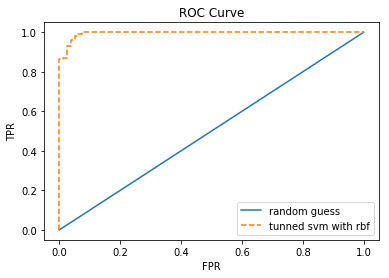

In [315]:
plt.plot([0, 1], [0, 1], label="random guess") # random model
plt.plot(FPR, TPR,  '--', label= "tunned svm with rbf")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

# Q4 Print Area under the curve(AUC) for tunned SVM. 

In [2]:
# Write code here



It is a pretty good model.